**Этот ноутбук - упражнение в курсе [Intro to Deep Learning](https://www.kaggle.com/learn/intro-to-deep-learning). Учебный материал можно посмотреть [по этой ссылке](https://www.kaggle.com/ryanholbrook/dropout-and-batch-normalization).**

---



# Введение #

В этом упражнении вы добавите dropout в модель *Spotify* из упражнения 4 и увидите, как batch normalization позволяет успешно обучать модели на сложных датасетах.

Запустите следующую ячейку, чтобы начать!


In [1]:
# Setup plotting
import matplotlib.pyplot as plt
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

Сначала загрузите набор данных *Spotify*.


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('../dataset/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

/Users/flexonafft/KaggleLearning/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Input shape: [18]


# 1) Добавьте Dropout в модель Spotify

Вот последняя модель из упражнения 4. Добавьте два слоя dropout: один после слоя `Dense` с 128 нейронами и один после слоя `Dense` с 64 нейронами. Для обоих установите `rate` равным `0.3`.


In [4]:
# YOUR CODE HERE: Add two 30% dropout layers, one after 128 and one after 64
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])

/Users/flexonafft/KaggleLearning/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Lines below will give you a hint or solution code
#q_1.hint()
#q_1.solution()

Теперь запустите следующую ячейку, чтобы обучить модель и увидеть эффект добавления dropout.


Minimum Validation Loss: 0.1920


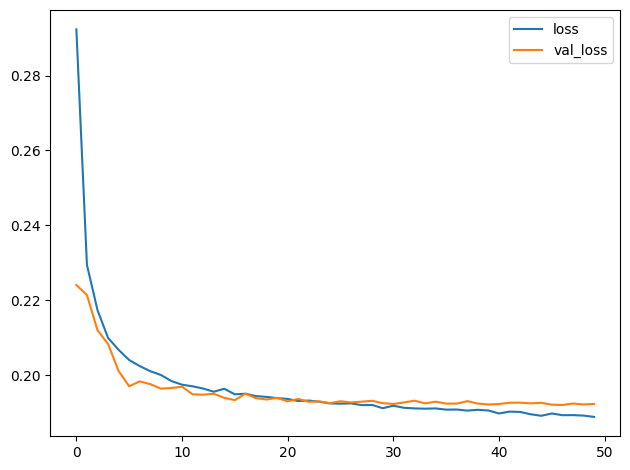

In [5]:
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

# 2) Оцените Dropout

Вспомните из упражнения 4, что эта модель начинала переобучаться примерно на эпохе 5. Похоже, что добавление dropout в этот раз помогло предотвратить переобучение?


Теперь сменим тему и посмотрим, как batch normalization может исправлять проблемы в обучении.

Загрузите набор данных *Concrete*. В этот раз мы не будем делать стандартизацию. Так эффект batch normalization будет гораздо заметнее.


In [6]:
import pandas as pd

concrete = pd.read_csv('../dataset/concrete.csv')
df = concrete.copy()

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = df_train.drop('CompressiveStrength', axis=1)
X_valid = df_valid.drop('CompressiveStrength', axis=1)
y_train = df_train['CompressiveStrength']
y_valid = df_valid['CompressiveStrength']

input_shape = [X_train.shape[1]]

Запустите следующую ячейку, чтобы обучить сеть на нестандартизированных данных *Concrete*.


/Users/flexonafft/KaggleLearning/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Minimum Validation Loss: nan


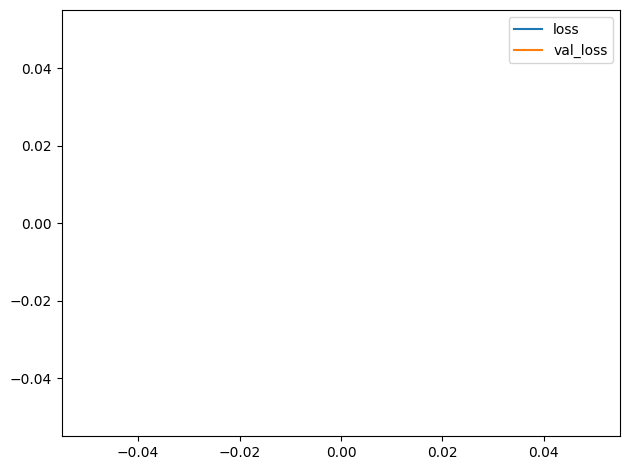

In [7]:
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),    
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='sgd', # SGD is more sensitive to differences of scale
    loss='mae',
    metrics=['mae'],
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

У вас получился пустой график? Обучение этой сети на этом наборе данных обычно не удается. Даже когда оно сходится (из-за удачной инициализации весов), оно часто сходится к очень большому числу.

# 3) Добавьте слои Batch Normalization

Batch normalization может помочь исправить такие проблемы.

Добавьте четыре слоя `BatchNormalization`, по одному перед каждым полносвязным слоем. (Не забудьте перенести аргумент `input_shape` в новый первый слой.)


In [8]:
# YOUR CODE HERE: Add a BatchNormalization layer before each Dense layer
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])

/Users/flexonafft/KaggleLearning/.venv/lib/python3.9/site-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/flexonafft/KaggleLearning/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Lines below will give you a hint or solution code
#q_3.hint()
#q_3.solution()

Запустите следующую ячейку, чтобы проверить, позволит ли batch normalization обучить модель.


Minimum Validation Loss: 4.0882


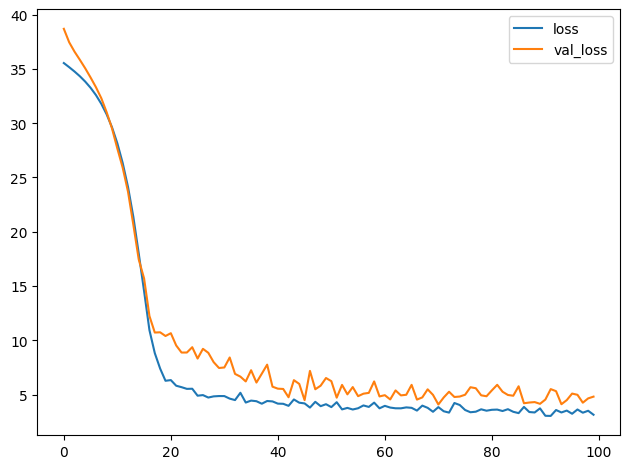

In [9]:
model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=EPOCHS,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

# 4) Оцените Batch Normalization

Помогло ли добавление batch normalization?


# Продолжайте #

[**Создайте нейронные сети**](https://www.kaggle.com/ryanholbrook/binary-classification) для бинарной классификации.


---




*Есть вопросы или комментарии? Зайдите на [форум обсуждения курса](https://www.kaggle.com/learn/intro-to-deep-learning/discussion), чтобы пообщаться с другими учащимися.*
